## Estadistica Aplicada 

Sesion 17 - 25 octubre 

Ana Sofia Saucedo Garcia
1946646

Grupo 42


In [2]:
# Librerias basicas

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [1]:
## especializadas 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.arima.model import ARIMA

## pmdarima

import pmdarima as pm 

In [3]:
# datos

desempleo_mex= pd.read_excel('desempleo_mex.xlsx')

In [6]:
desempleo_mex.dtypes

meses                 object
tasa de desempleo    float64
dtype: object

In [4]:
desempleo_mex.head()

,meses,tasa de desempleo
0,2005/01,3.951998
1,2005/02,3.773302
2,2005/03,3.627075
3,2005/04,3.363412
4,2005/05,3.303693


In [7]:
## convertir en tiempo
## hacerlo index
## asignarle frecuencia 

desempleo_mex['meses']=pd.to_datetime(desempleo_mex['meses'],format='%Y/%m')
desempleo_mex= desempleo_mex.set_index('meses')
desempleo_mex= desempleo_mex.asfreq('MS')

In [8]:
desempleo_mex.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01'],
              dtype='datetime64[ns]', name='meses', length=224, freq='MS')

In [9]:
## missing values 

desempleo_mex.isnull().sum()


tasa de desempleo    0
dtype: int64

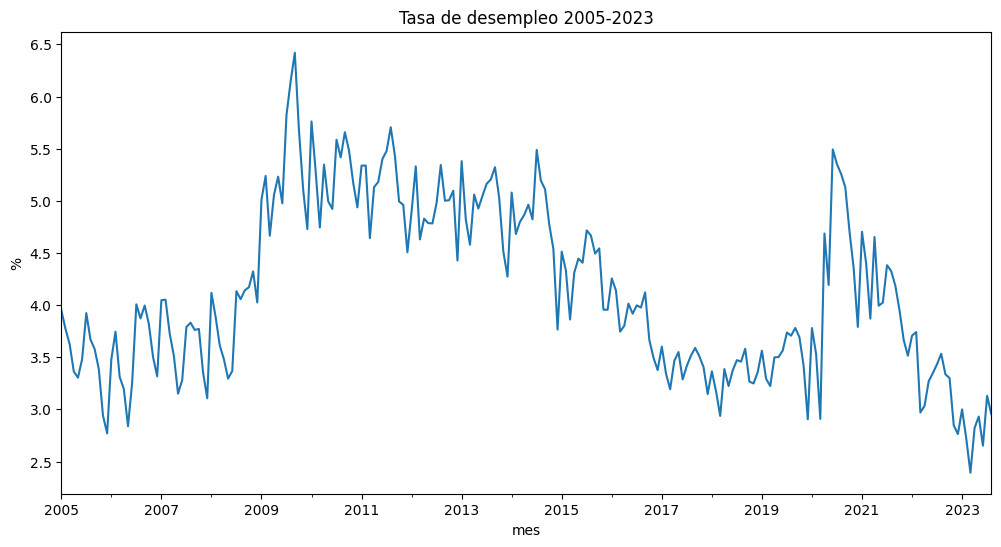

In [11]:
## grafcar serie 

desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.xlabel('mes')
plt.ylabel('%')
plt.title('Tasa de desempleo 2005-2023');


In [12]:
## prueba de dickey-fuller aumentada

prueba_adf= adfuller(desempleo_mex['tasa de desempleo'])
pvalue= prueba_adf[1]
pvalue.round(2)

0.25

No rechazamos $H_0$ , el desempleo es una serie no estacionaria

In [13]:
## primeras diferencias 

desempleo_mex['desempleo_diff']=desempleo_mex['tasa de desempleo'].diff()

<Axes: xlabel='meses'>

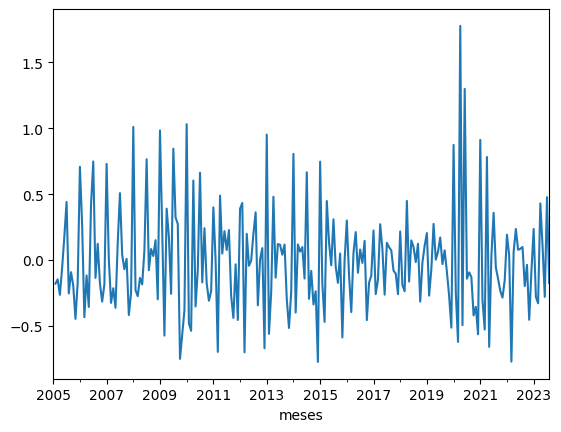

In [15]:

desempleo_mex['desempleo_diff'].plot()

In [14]:
prueba_adf= adfuller(desempleo_mex['desempleo_diff'].dropna())
pvalue1= prueba_adf[1]
pvalue1.round(2)

0.01

Rechazamos $H_0$ , las primeras diferencias de desempleo son una serie estacionaria

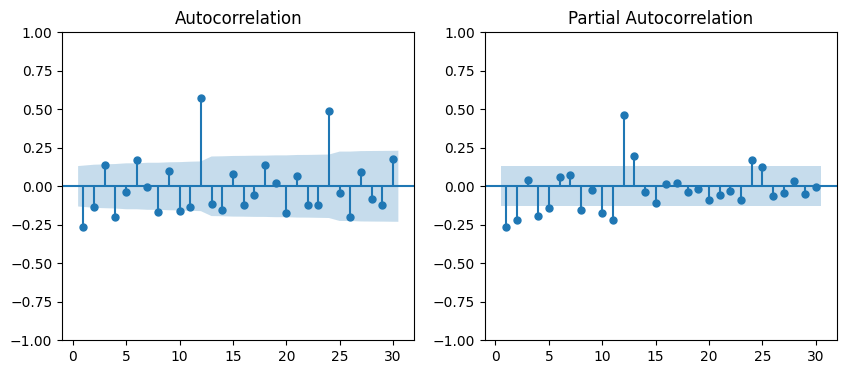

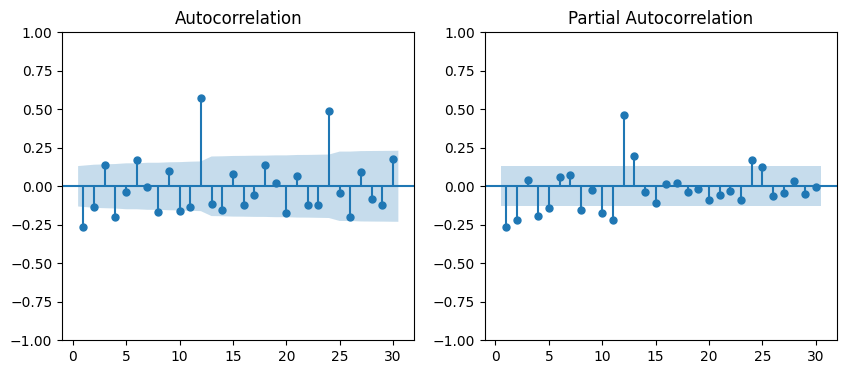

In [16]:
## graficas de correlación 

ig,ax= plt.subplots(1,2,figsize=(10,4))

## 1er 
plot_acf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=30,ax=ax[0])

## 2 da
plot_pacf(desempleo_mex['desempleo_diff'].dropna(),zero=False,lags=30,ax=ax[1])


Con las graficas de correlacion dado que emerge un patron que se repite , estamos ante una serie estacional , es decir, hay meses que el desempleo siempre o meses que el desempleo sieempre baja

In [18]:
## Encontrar el orden del SARIMA

pm.auto_arima(desempleo_mex['tasa de desempleo'],
              start_p=1,start_q=1,
              max_p=7,max_q=7,
              ic='aic',
              seasonal=True,
              m=12,
              start_P=1, start_Q=1,
              max_P=7, max_Q=7
              )

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

la tasa de desempleo es un SARIMA (1,1,0)(1,0,1,12)

In [19]:
## modelo

model= ARIMA(desempleo_mex['tasa de desempleo'],
             order=(1,1,0),
             seasonal_order=(1,0,1,12))

results=model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  tasa de desempleo   No. Observations:                  224
Model:             ARIMA(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -28.306
Date:                            Wed, 25 Oct 2023   AIC                             64.613
Time:                                    15:52:42   BIC                             78.241
Sample:                                01-01-2005   HQIC                            70.115
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3689      0.061     -6.075      0.000      -0.488      -0.250
ar.S.L12       0.9763      0.014   

In [20]:
desempleo_mex['desempleo_arima']=results.predict()

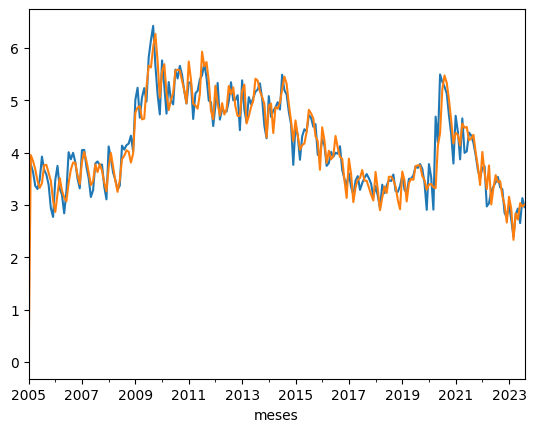

In [22]:
desempleo_mex['tasa de desempleo'].plot()
desempleo_mex['desempleo_arima'].plot();

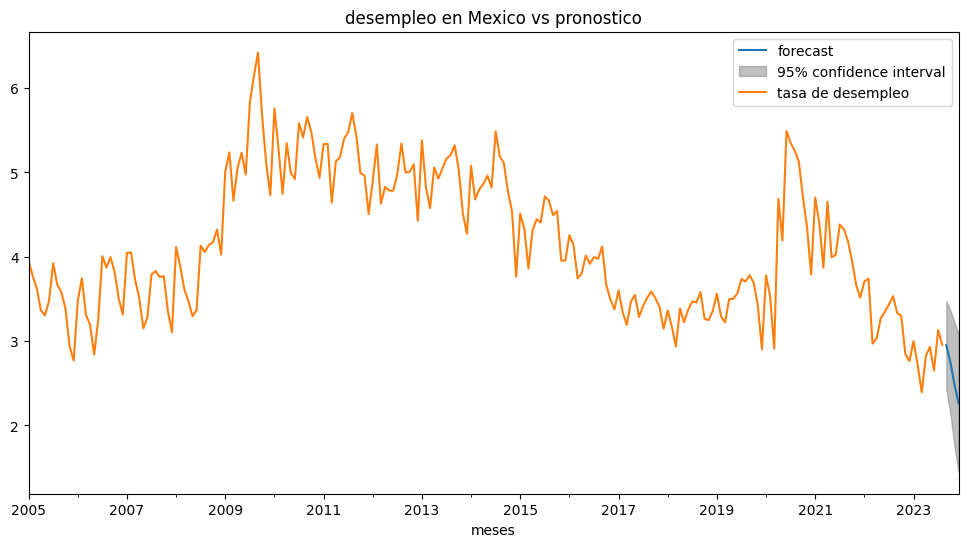

In [23]:
# grafica del pronostico futuro 
plot_predict(results,'2023-09-01','2023-12-01')
desempleo_mex['tasa de desempleo'].plot(figsize=(12,6))
plt.title('desempleo en Mexico vs pronostico')
plt.legend()
plt.show()

In [24]:
desempleo_mex.tail()

,tasa de desempleo,desempleo_diff,desempleo_arima
meses,,,
2023-04-01,2.822799,0.430258,2.837606
2023-05-01,2.931125,0.108327,2.722100
2023-06-01,2.652033,-0.279093,3.034390
2023-07-01,3.129870,0.477837,2.968333
2023-08-01,2.955346,-0.174524,3.007015


Pronostico con los intervalos 

In [25]:
forecast= results.get_forecast(steps=4)
forecast_mean= forecast.predicted_mean
forecast_ci= forecast.conf_int()

In [26]:
inicio= '2023-09-01'
fin='2023-12-01'

In [27]:
pronostico_valor= forecast_mean[inicio:fin]
pronostico_intervalos= forecast_ci.loc[inicio:fin]

In [31]:
pro_desempleo= pd.DataFrame({
    'pronostico': pronostico_valor,
    'limite inferior': pronostico_intervalos.iloc[:,0],
    'limite superior': pronostico_intervalos.iloc[:,1]
})

In [32]:
pro_desempleo

,pronostico,limite inferior,limite superior
2023-09-01,2.951735,2.431389,3.472082
2023-10-01,2.750669,2.135374,3.365963
2023-11-01,2.483561,1.750114,3.217009
2023-12-01,2.262441,1.439566,3.085317


In [36]:
print(f'Para septiembre pronosticamos una tasa de desempleo de :{pro_desempleo.iloc[0,0].round(2)}% \n pero puede estar entre:{pro_desempleo.iloc[0,1].round(2)}% y {pro_desempleo.iloc[0,2].round(2)}% con 95% de confianza')

Para septiembre pronosticamos una tasa de desempleo de :2.95% 
 pero puede estar entre:2.43% y 3.47% con 95% de confianza
